In [181]:
import pandas as pd
import numpy as np

text_field = "text"
label_field = "label"
data_frame_name = "IMDB_reviews.csv"

df = pd.read_csv(data_frame_name)
print(df.size)
df.head(10)

10000


,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0
5,"I saw this film on September 1st, 2005 in Indi...",1
6,I saw a screening of this movie last night. I ...,0
7,William Hurt may not be an American matinee id...,1
8,IT IS A PIECE OF CRAP! not funny at all. durin...,0
9,I'M BOUT IT(1997)<br /><br />Developed & publi...,0


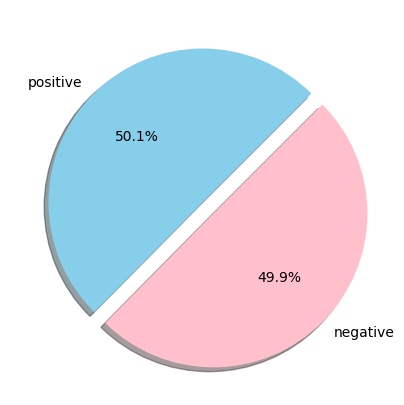

In [182]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))
colors = ["skyblue", "pink"]
positive = df[df[label_field]==1]
negative = df[df[label_field]==0]

counts = [positive[label_field].count(), negative[label_field].count()]

legpie = plt.pie(
    counts,
    labels=["positive", "negative"],
    autopct="%1.1f%%",
    shadow=True,
    colors=colors,
    startangle=45,
    explode=(0, 0.1)
)


In [183]:
import re
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO

clean = True

rep_emoji = {re.escape(k): v for k, v in UNICODE_EMOJI.items()}
pat_emoji = re.compile('('+'|'.join(rep_emoji.keys()).replace('/', '\\/')+')')

rep_emoti = {re.escape(k): v for k, v in EMOTICONS_EMO.items()}
pat_emoti = re.compile('|'.join(rep_emoti.keys()).replace('/', '\\/'))


def clean_text(df: pd.DataFrame, text_field, emoji: str="replace", emoticons: str="replace"):
    df_c = df.copy()
    df_c[text_field] = df_c[text_field].str.replace(r"<[^>]*>", "", regex=True)
    df_c[text_field] = df_c[text_field].str.replace(r"http\S+", "", regex=True)
    df_c[text_field] = df_c[text_field].str.replace(r"http", "", regex=True)
    df_c[text_field] = df_c[text_field].str.replace(r"@\S+", "", regex=True)

    # change emoji and emoticons
    emoti_replacer = "" if emoticons ==  "remove" else lambda m: "("+rep_emoti[re.escape(m.group(0))].replace(" ", "_")+")"
    df_c[text_field] = df_c[text_field].str.replace(pat_emoti, emoti_replacer)

    emoji_replacer = "" if emoticons ==  "remove" else lambda m: "("+rep_emoji[re.escape(m.group(0))]+")"
    df_c[text_field] = df_c[text_field].str.replace(pat_emoji, emoji_replacer)

    # replace dates
    df_c[text_field] = df_c[text_field].str.replace(r"\d{1,2}[/-]\d{1,2}[/-]\d{2,4}", "datevalue", regex=True) # m*d*Y
    df_c[text_field] = df_c[text_field].str.replace(r"(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-zA-Z.,-]*[\s-]?(\d{1,2})?[,\s-]?[\s]?\d{4}", "datevalue", regex=True) # Month*d*Y
    df_c[text_field] = df_c[text_field].str.replace(r"\d{1,2}[/-]\d{4}", "datevalue", regex=True) # m*Y
    df_c[text_field] = df_c[text_field].str.replace(r"\d{4}", "datevalue", regex=True) # Y

    # # replace residual non text character
    df_c[text_field] = df_c[text_field].str.replace("`", "\'", regex=True)
    df_c[text_field] = df_c[text_field].str.replace(r"[^A-Za-z0-9@\'\_]", " ", regex=True)
    df_c[text_field] = df_c[text_field].str.replace(r"@", "at", regex=True)
    
    df_c[text_field] = df_c[text_field].str.lower()

    return df_c

if clean:
    df_clean = clean_text(df, text_field)
    df_clean.to_csv(data_frame_name.split(".")[0]+"_clean.csv", index=False)

    print(df_clean.head(10))


                                                text  label
0  i always wrote this series off as being a comp...      0
1  1st watched datevalue   3 out of 10 dir steve ...      0
2  this movie was so poorly written and directed ...      0
3  the most interesting thing about miryang  secr...      1
4  when i first read about  berlin am meer  i did...      0
5  i saw this film on september 1st  datevalue in...      1
6  i saw a screening of this movie last night  i ...      0
7  william hurt may not be an american matinee id...      1
8  it is a piece of crap  not funny at all  durin...      0
9  i'm bout it datevalue developed   published by...      0


In [ ]:
UNICODE_EMOJI

In [184]:
clean_df = pd.read_csv(data_frame_name.split(".")[0]+"_clean.csv")
clean_df.head(10)

,text,label
0,i always wrote this series off as being a comp...,0
1,1st watched datevalue 3 out of 10 dir steve ...,0
2,this movie was so poorly written and directed ...,0
3,the most interesting thing about miryang secr...,1
4,when i first read about berlin am meer i did...,0
5,i saw this film on september 1st datevalue in...,1
6,i saw a screening of this movie last night i ...,0
7,william hurt may not be an american matinee id...,1
8,it is a piece of crap not funny at all durin...,0
9,i'm bout it datevalue developed published by...,0


In [324]:
import nltk
import spacy
from nltk.corpus import stopwords

nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def get_clean_tokens(text):
    doc = nlp(text)
    restricted_tokens = stopwords.words("english") + ["\'", "\'s", "`", "`s"]
    lemmatized = [token.lemma_.lower() for token in doc if not token.lemma_.isspace()]
    return [token for token in lemmatized if
        token not in restricted_tokens and
        not token.isnumeric()
    ]

clean_df["tokens"] = clean_df[text_field].apply(get_clean_tokens)
clean_df.head(10)



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/constantine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,tokens
0,i always wrote this series off as being a comp...,0,"[always, write, series, complete, stink, f, ji..."
1,1st watched datevalue 3 out of 10 dir steve ...,0,"[1st, watch, datevalue, dir, steve, purcell, t..."
2,this movie was so poorly written and directed ...,0,"[movie, poorly, write, direct, fall, asleep, m..."
3,the most interesting thing about miryang secr...,1,"[interesting, thing, miryang, secret, sunshine..."
4,when i first read about berlin am meer i did...,0,"[first, read, berlin, meer, expect, much, thin..."
5,i saw this film on september 1st datevalue in...,1,"[see, film, september, 1st, datevalue, indiana..."
6,i saw a screening of this movie last night i ...,0,"[see, screening, movie, last, night, high, exp..."
7,william hurt may not be an american matinee id...,1,"[william, hurt, may, american, matinee, idol, ..."
8,it is a piece of crap not funny at all durin...,0,"[piece, crap, funny, whole, movie, nothing, ev..."
9,i'm bout it datevalue developed published by...,0,"[bout, datevalue, develop, publish, limit, fil..."


In [186]:
all_words = [word for tokens in clean_df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_df["tokens"]]
vocab = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(sentence_lengths))

sentence_lengths_1 = [len(tokens) for tokens in clean_df[clean_df[label_field]==1]["tokens"]]
sentence_lengths_0 = [len(tokens) for tokens in clean_df[clean_df[label_field]==0]["tokens"]]

595250 words total, with a vocabulary size of 31504
Max sentence length is 1137


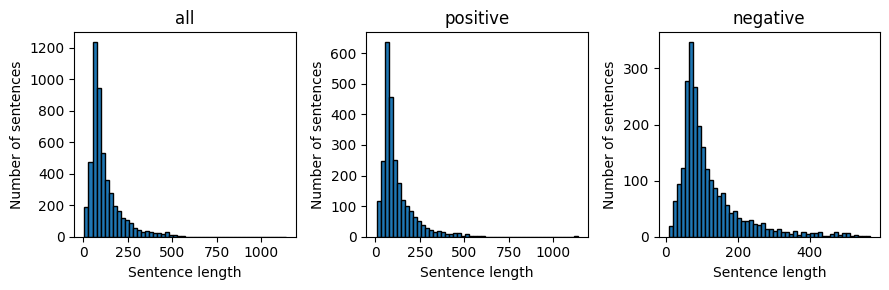

count    5000.00000
mean      119.05000
std        91.19323
min         7.00000
25%        64.00000
50%        88.00000
75%       144.00000
max      1137.00000
dtype: float64
count    2505.000000
mean      118.363673
std        93.767517
min         7.000000
25%        63.000000
50%        86.000000
75%       142.000000
max      1137.000000
dtype: float64
count    2495.000000
mean      119.739078
std        88.546825
min         8.000000
25%        65.000000
50%        90.000000
75%       145.000000
max       567.000000
dtype: float64


In [187]:
import matplotlib.pyplot as plt

fig, [axs_all, axs_1, axs_0] = plt.subplots(ncols=3, figsize=(9, 3))


axs_all.set_title("all")
axs_all.set_xlabel('Sentence length')
axs_all.set_ylabel('Number of sentences')
axs_all.hist(sentence_lengths, 50, edgecolor="black")

axs_1.set_title("positive")
axs_1.set_xlabel('Sentence length')
axs_1.set_ylabel('Number of sentences')
axs_1.hist(sentence_lengths_1, 50, edgecolor="black")

axs_0.set_title("negative")
axs_0.set_xlabel('Sentence length')
axs_0.set_ylabel('Number of sentences')
axs_0.hist(sentence_lengths_0, 50, edgecolor="black")
fig.tight_layout()

plt.show()
print(pd.Series(sentence_lengths).describe())
print(pd.Series(sentence_lengths_1).describe())
print(pd.Series(sentence_lengths_0).describe())

In [325]:
from sklearn.model_selection import train_test_split

df_prepared = clean_df.copy()
df_prepared["label"] = df_prepared[label_field].apply(lambda label: f"__label__{str(label)}")
df_prepared["text"] = df_prepared["tokens"].apply(lambda tokens: " ".join(tokens))
df_prepared = df_prepared[["label", "text"]]

list_corpus = df_prepared["text"]
list_labels = df_prepared["label"]

X_train, X_test, Y_train, Y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)
train_data = np.array([Y_train, X_train]).T
test_data = np.array([Y_test, X_test]).T

train_file = f"{data_frame_name.split('.')[0]}_clean.train"
test_file = f"{data_frame_name.split('.')[0]}_clean.test"

np.savetxt(train_file, train_data, delimiter=" ", fmt="%s")
np.savetxt(test_file, test_data, delimiter=" ", fmt="%s")

In [326]:
import fasttext
import numpy

def get_fasttext_confusion_matrix(model: fasttext.FastText._FastText, test_data):
    predict = np.vectorize(lambda x: model.predict(x, k=1)[0][0])
    
    Y_test = test_data[:,0]
    Y_pred = predict(test_data[:,1])

    pos = "__label__1"
    neg = "__label__0"

    Y_test_pred_pos = Y_test[Y_pred==pos]
    Y_test_pred_neg = Y_test[Y_pred==neg]

    TP = (Y_test_pred_pos==pos).sum()
    FN = (Y_test_pred_neg==pos).sum()
    FP = (Y_test_pred_pos==neg).sum()
    TN = (Y_test_pred_neg==neg).sum()

    return pd.DataFrame(
        data=[[TP, FN], [FP, TN]],
        columns=["pred_pos", "pred_fair"],
        index=["true_fraud", "true_fair"]
    )

def calc_stats(confussion_matrix):
    TP = confussion_matrix.iloc[0,0]
    FN = confussion_matrix.iloc[0,1]
    FP = confussion_matrix.iloc[1,0]
    TN = confussion_matrix.iloc[1,1]

    PR = TP/(TP+FP)
    RE = TP/(TP+FN)
    SP = FP/(FP+TN)
    AC = (TP+TN)/(TP+FP+FN+TN)

    return pd.DataFrame(data=[PR, RE, SP, AC], index=["Precission", "Recall", "Specificity", "Accuracy"])

In [327]:
import fasttext

model = fasttext.train_supervised(input=train_file, epoch=50, lr=0.2, loss="softmax", wordNgrams=1, minCount=1, thread=12)
model.test(test_file)


Read 0M words
Number of words:  28500
Number of labels: 2
Progress: 100.0% words/sec/thread: 2236683 lr:  0.000000 avg.loss:  0.054611 ETA:   0h 0m 0s


(1000, 0.819, 0.819)

In [191]:
cm = get_fasttext_confusion_matrix(model, test_data)
print(cm)

calc_stats(cm)

            pred_pos  pred_fair
true_fraud       416         80
true_fair         98        406


,0
Precission,0.809339
Recall,0.838710
Specificity,0.194444
Accuracy,0.822000


In [330]:
import fasttext

model = fasttext.train_supervised(input=train_file, epoch=50, lr=0.2, loss="softmax", wordNgrams=2, minCount=1, thread=12)
model.test(test_file)


Read 0M words
Number of words:  28500
Number of labels: 2
Progress: 100.0% words/sec/thread: 1059325 lr:  0.000000 avg.loss:  0.074926 ETA:   0h 0m 0s


(1000, 0.855, 0.855)

In [332]:
cm = get_fasttext_confusion_matrix(model, test_data)
print(cm)

calc_stats(cm)
model.save_model("fasttext_model.bin")

            pred_pos  pred_fair
true_fraud       427         69
true_fair         76        428


In [194]:
import fasttext

model = fasttext.train_supervised(input=train_file, epoch=50, lr=0.2, loss="softmax", wordNgrams=3, minCount=1, thread=12)
model.test(test_file)


Read 0M words
Number of words:  28500
Number of labels: 2
Progress: 100.0% words/sec/thread:  575076 lr:  0.000000 avg.loss:  0.099788 ETA:   0h 0m 0s


(1000, 0.849, 0.849)

In [195]:
cm = get_fasttext_confusion_matrix(model, test_data)
print(cm)

calc_stats(cm)

            pred_pos  pred_fair
true_fraud       426         70
true_fair         81        423


,0
Precission,0.840237
Recall,0.858871
Specificity,0.160714
Accuracy,0.849000


In [196]:
import fasttext

model = fasttext.train_supervised(input=train_file, epoch=50, lr=0.2, loss="softmax", wordNgrams=4, minCount=1, thread=12)
model.test(test_file)


Read 0M words
Number of words:  28500
Number of labels: 2
Progress: 100.0% words/sec/thread:  410812 lr:  0.000000 avg.loss:  0.126692 ETA:   0h 0m 0s


(1000, 0.839, 0.839)

In [197]:
cm = get_fasttext_confusion_matrix(model, test_data)
print(cm)

calc_stats(cm)

            pred_pos  pred_fair
true_fraud       426         70
true_fair         91        413


,0
Precission,0.823985
Recall,0.858871
Specificity,0.180556
Accuracy,0.839000


In [312]:
import fasttext

model = fasttext.train_supervised(input=train_file, epoch=50, lr=0.2, loss="softmax", wordNgrams=2, minCount=1, thread=12)


Read 0M words
Number of words:  28500
Number of labels: 2
Progress: 100.0% words/sec/thread: 1006354 lr:  0.000000 avg.loss:  0.181525 ETA:   0h 0m 0s


            pred_pos  pred_fair
true_fraud       427         69
true_fair         80        424
                    0
Precission   0.842209
Recall       0.860887
Specificity  0.158730
Accuracy     0.851000


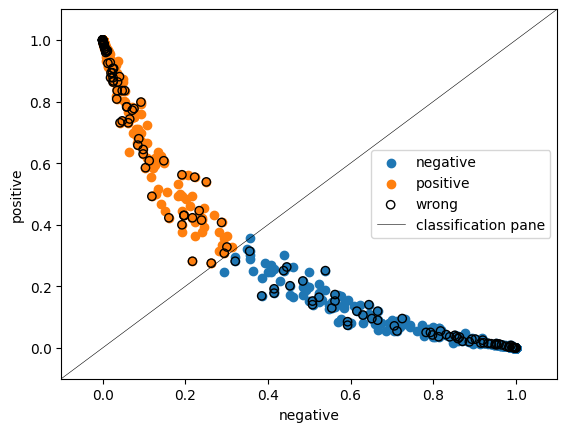

In [322]:
cm = get_fasttext_confusion_matrix(model, test_data)
print(cm)
print(calc_stats(cm))

data_pred = np.array([model.predict(text, k=2) for text in test_data[:,1]])
points = []
labels = []

for r in data_pred:
    labels.append(r[0][0])
    if r[0][0] == "__label__0":
        points.append((float(r[1][0]), float(r[1][1])))
    else:
        points.append((float(r[1][1]), float(r[1][0])))

points = np.array(points)
labels = np.array(labels)
points_pos = points[labels=="__label__1"]
points_neg = points[labels=="__label__0"]
points_wrong = points[labels!=test_data[:,0]]

plt.xlabel("negative")
plt.ylabel("positive")
plt.xlim((-0.1, 1.1))
plt.ylim((-0.1, 1.1))
plt.scatter(points_neg[:,0], points_neg[:,1], label="negative")
plt.scatter(points_pos[:,0], points_pos[:,1], label="positive")
plt.scatter(points_wrong[:,0], points_wrong[:,1], c='none', edgecolors="black", label="wrong")
plt.plot(np.linspace(-.5, 1.5, 3), np.linspace(-.5, 1.5, 3), linewidth=0.4, c="black", label="classification pane")
plt.legend()
plt.show()